# Introduction
Thanks for being interested in an internship and completing our example problem! The following set of prompts should guide you through some basic deep learning related tools which are commonly used in our work. If you get stuck, document what you tried with code and comments. 

The problems are made to be open ended. Include comments about what you tried and what you learned. Plots are great!  

Its fine to use code or tutorials that you find on the web, but please include a link to where you found them! 


In [2]:
# # If you are using Colab, run this cell to install pytorch and torchvision! 
# !pip3 install torch torchvision

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import os
import random

%load_ext autoreload
%autoreload 2
%matplotlib inline

/Users/zijing/miniforge3/envs/rmft/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set the random seed
seed = 111
random.seed(seed)

# Set random seed for numpy
np.random.seed(seed)

# Set random seed for PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# MNIST Model
Train an MNIST convolutional neural network model in PyTorch to do a visual classification task. Find a model that reaches at least 90% accuracy on the task on the test set. Print the training and test set accuracy. 

Hint: A single layer convolutional neural network with a fully connected layer at the end should be sufficient for this! 

In [4]:
# Reference: https://github.com/pytorch/examples/blob/main/mnist/main.py

class MNISTModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten(start_dim=-3, end_dim=-1)
        self.fc = nn.Linear(21632, 10)
        self.softmax = nn.LogSoftmax(dim=1)
        # self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        # x = x.view(x.size(0), -1)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.softmax(x)
        return x
    
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        _, pred = torch.max(output, 1)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
        running_corrects += torch.sum(pred == target)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects / len(train_loader.dataset)

    return epoch_loss, epoch_acc
    
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    test_corrects = 0
    with torch.no_grad():
        for data, target in tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output, 1)
            loss = criterion(output, target)

            test_loss += loss.item() 
            test_corrects += torch.sum(pred == target)

    test_loss = test_loss / len(test_loader.dataset)
    test_acc = test_corrects / len(test_loader.dataset)

    return test_loss, test_acc
    
# Set up the dataloaders
train_dataset = MNIST(download=True, root="data", train=True, transform=Compose([ToTensor()]))
test_dataset = MNIST(download=False, root="data", train=False, transform=Compose([ToTensor()]))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

# Set up the model, optimizer, and loss function
model = MNISTModel()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss() # use LogSoftmax + NLLLoss instead to retrieve the log-probability

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# Save the best model by test accuracy
best_acc = 0
save_path = "models/"
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Epoch = 10 is found sufficient
for epoch in tqdm(range(10)):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), save_path + "mnist_cnn.pt")
    
    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} Test Loss: {test_loss:.4f} Test Acc: {test_acc:.4f}')

 10%|█         | 1/10 [00:14<02:07, 14.18s/it]

Epoch 1: Train Loss: 0.2335 Train Acc: 0.9290 Test Loss: 0.0015 Test Acc: 0.9712


 20%|██        | 2/10 [00:28<01:53, 14.14s/it]

Epoch 2: Train Loss: 0.0798 Train Acc: 0.9764 Test Loss: 0.0011 Test Acc: 0.9764


 30%|███       | 3/10 [00:41<01:37, 13.86s/it]

Epoch 3: Train Loss: 0.0560 Train Acc: 0.9827 Test Loss: 0.0010 Test Acc: 0.9791


 40%|████      | 4/10 [00:55<01:23, 13.88s/it]

Epoch 4: Train Loss: 0.0431 Train Acc: 0.9865 Test Loss: 0.0010 Test Acc: 0.9789


 50%|█████     | 5/10 [01:09<01:08, 13.67s/it]

Epoch 5: Train Loss: 0.0339 Train Acc: 0.9893 Test Loss: 0.0010 Test Acc: 0.9794


 60%|██████    | 6/10 [01:22<00:54, 13.52s/it]

Epoch 6: Train Loss: 0.0278 Train Acc: 0.9911 Test Loss: 0.0010 Test Acc: 0.9803


 70%|███████   | 7/10 [01:35<00:40, 13.42s/it]

Epoch 7: Train Loss: 0.0222 Train Acc: 0.9928 Test Loss: 0.0010 Test Acc: 0.9803


 80%|████████  | 8/10 [01:48<00:26, 13.35s/it]

Epoch 8: Train Loss: 0.0180 Train Acc: 0.9942 Test Loss: 0.0013 Test Acc: 0.9776


 90%|█████████ | 9/10 [02:02<00:13, 13.40s/it]

Epoch 9: Train Loss: 0.0140 Train Acc: 0.9954 Test Loss: 0.0012 Test Acc: 0.9782


100%|██████████| 10/10 [02:15<00:00, 13.51s/it]

Epoch 10: Train Loss: 0.0114 Train Acc: 0.9962 Test Loss: 0.0012 Test Acc: 0.9795


In [5]:
# Load the best model for evaluation
model.load_state_dict(torch.load(save_path + "mnist_cnn.pt"))
model.eval()

MNISTModel(
  (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (flatten): Flatten(start_dim=-3, end_dim=-1)
  (fc): Linear(in_features=21632, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)

# Explore the model

After your model is trained, lets look at some of the features. 

## Visualize some of the first layer of filters. 
The network is convolutional, so you can look at one of the convolutional filters (ie kernels) as a 2D image. How do these filters change over training? 

Hint: Use plt.matshow for this! 

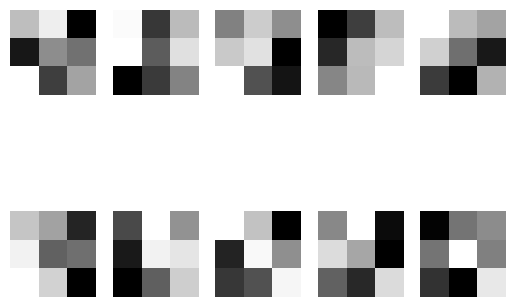

In [6]:
# Reference: https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

# Access the weights of the convolutional layer
conv_weights = model.conv.weight.data.cpu().numpy()

# Plot the filters as images
fig, ax = plt.subplots(nrows=2, ncols=5)
for i in range(2):
    for j in range(5):
        ax[i][j].matshow(conv_weights[i*5+j][0], cmap='gray')
        ax[i][j].axis('off')

plt.show()


## Plot the activations
Take one (or a few) of the images in the validation set and run it through the network. Look at the *activations* in the first layer (this is the output from a given convolutional kernel). Show this for a few of the filters. 

Hint: Use plt.matshow for this as well! 

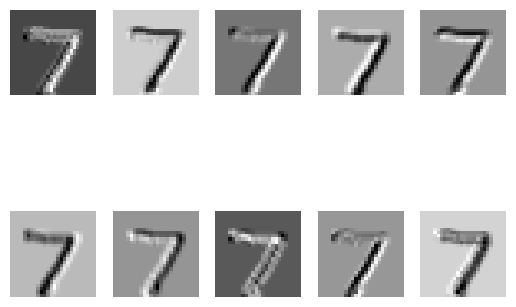

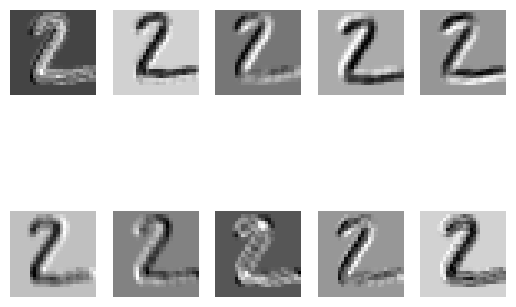

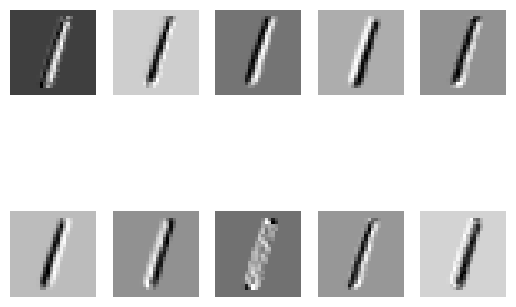

In [7]:
activations = []

for i in range(3):
    # Select a image from the validation set
    image, label = test_dataset[i]
    image = image.unsqueeze(0)

    # Pass the image through the trained model
    model.eval()
    with torch.no_grad():
        conv_output = model.conv(image)
        activations.append(conv_output)

    # Plot the activations for a few filters
    fig, ax = plt.subplots(nrows=2, ncols=5)
    for i in range(2):
        for j in range(5):
            activation = conv_output[0, i*5+j].cpu().numpy()
            ax[i][j].matshow(activation, cmap='gray')
            ax[i][j].axis('off')

    plt.show()

        

# Bonus Exploration (not necessary to complete, but may be interesting if you found this fun)

Congrats! You trained a convolutional neural network and investigated some of the features. In our group, we are interested in the underlying geometry of biological and artificial neural networks. We take things a few steps further, and a few ways to look at this are below. 

## Additional analysis of the activations. 

The structure of the network can be investigated in many different ways. Here we will look at singular values of the activations. Measure the activations for 100 images for a single layer of the network (we recommend the layer immediately before classification). Then, perform SVD (singular value decomposition) on the activations and plot the singular values. 

In [8]:
from sklearn.decomposition import PCA

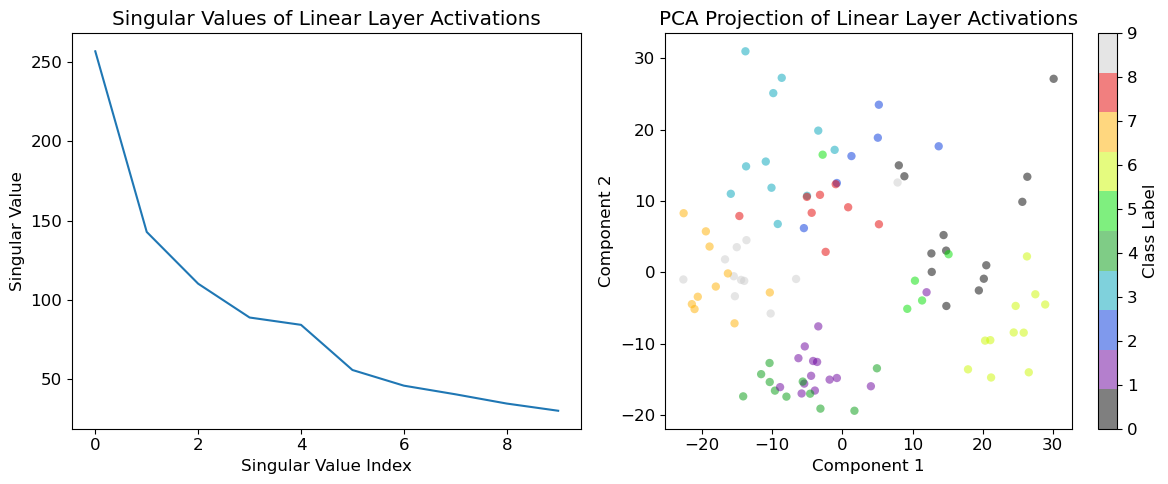

In [9]:
activations = []
labels = []

# Get the activations for a large number of images
for i in range(100):
    image, label = train_dataset[i]
    image = image.unsqueeze(0)

    model.eval()
    with torch.no_grad():
        act = model.conv(image)
        act = model.relu(act).view(1, -1)
        act = model.fc(act)
        # act = model.softmax(act) 
        activations.append(act)
        labels.append(label)

activations = torch.cat(activations, dim=0)

u, s, vh = torch.linalg.svd(activations)
plt.rcParams.update({'font.size': 12, 'figure.figsize': (12, 5)})

# Create figure and axes objects
fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot singular values
ax1.plot(s)
ax1.set_xlabel("Singular Value Index")
ax1.set_ylabel("Singular Value")
ax1.set_title("Singular Values of Linear Layer Activations")

# Perform PCA
pca = PCA(n_components=2)
projected_activations = pca.fit_transform(activations)

# Plot PCA
scatter = ax2.scatter(projected_activations[:, 0], projected_activations[:, 1], c=labels, edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('nipy_spectral', 10))
ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')
ax2.set_title('PCA Projection of Linear Layer Activations')

# Add colorbar
colorbar = plt.colorbar(scatter, ax=ax2, ticks=np.unique(labels))
colorbar.set_label('Class Label')

# Show the figure
plt.tight_layout()
plt.show()

# reset the matplotlib parameters
plt.rcParams.update({})

✨**What I found** 
- For the fully connected layer, the singular values for the first 100 image activation have values as shown in the plot. We also project the `(100, 10)` activation matrix into the 2D space via PCA. We can see good pattern of within class clustering. It indicates a reasonable linear separation in the neural manifold space for the linear layer, which will be quantified by its improved capacity in the next subsection. 

## Geometry of network representations

The main focus of the NeuroAI group is on the geometry of biological and artificial neural network representations. 

Try to look at the Capacity of each layer of the trained neural network. How does the underlying geometry (the radius and dimension) change during training? 

Python code for anlayzing the geometry can be found here: 
https://github.com/schung039/neural_manifolds_replicaMFT

Additional references to the theory and usage of it for understanding neural networks are here: 
https://www.sciencedirect.com/science/article/pii/S0959438821001227

https://journals.aps.org/prx/pdf/10.1103/PhysRevX.8.031003

https://proceedings.neurips.cc/paper/2021/file/8383f931b0cefcc631f070480ef340e1-Paper.pdf


In [10]:
# Reference: https://github.com/schung039/neural_manifolds_replicaMFT
# Adapted code from the repo above as utils for neural manifold analysis
from mftma.utils.activation_extractor import extractor
from mftma.utils.make_manifold_data import make_manifold_data
from mftma.manifold_analysis_correlation import manifold_analysis_corr

### Create the manifold dataset

In [11]:
# MNIST dataset has 10 classes
sampled_classes = 10
# Use 50 examples for each object manifold
examples_per_class = 50

# Prepare the data for manifold analysis by sampling an equal number of examples from each class
data = make_manifold_data(train_dataset, sampled_classes, examples_per_class, seed=seed)
data = [d.to(device) for d in data]

### Extract activations from the model

In [12]:
# Extract the activations from the specified layers
# We are only interested in the activations of layers which transform the input data into a different dimensional space, i.e.
# We are not interested in the activations of layers which transform the input data into the same dimensional space, e.g. ReLU
activations = extractor(model, data, layer_types=['Conv2d', 'Linear'])
# activations = extractor(model, data) # while capacity of all layers were also inspected. 
#                                      # interesting to find ReLU decreases radius and center correlation 
#                                      # of the manifold, while it doesn't change the the capacity and
#                                      # dimension much.
list(activations.keys())

['layer_0_Input', 'layer_1_Conv2d', 'layer_4_Linear']

### Prepare activations for analysis

In [13]:
for layer, data, in activations.items():
    # Reshape the activation of the same class samples to be a 2D array of shape (N, 50)
    # print(len(data))
    X = [d.reshape(d.shape[0], -1).T for d in data]
    # print(X[0].shape)
    
    # Get the number of features in the flattened data
    N = X[0].shape[0]
    # If N is greater than 5000, do the random projection to 5000 features
    if N > 5000:
        print("Projecting {}".format(layer))
        M = np.random.randn(5000, N)
        M /= np.sqrt(np.sum(M*M, axis=1, keepdims=True))
        X = [np.matmul(M, d) for d in X]
    activations[layer] = X

Projecting layer_1_Conv2d


### Run the analysis on the prepped activations

And store the results for later plotting

In [14]:
capacities = []
radii = []
dimensions = []
correlations = []

for k, X, in activations.items():
    # Analyze each layer's activations
    a, r, d, r0, K = manifold_analysis_corr(X, 0, 300, n_reps=1)
    
    # Compute the mean values
    a = 1/np.mean(1/a)
    r = np.mean(r)
    d = np.mean(d)
    print("{} capacity: {:4f}, radius {:4f}, dimension {:4f}, correlation {:4f}".format(k, a, r, d, r0))
    
    # Store for later
    capacities.append(a)
    radii.append(r)
    dimensions.append(d)
    correlations.append(r0)

centers shape: (784, 10)
layer_0_Input capacity: 0.102317, radius 1.095650, dimension 16.729608, correlation 0.237636
centers shape: (5000, 10)
layer_1_Conv2d capacity: 0.106102, radius 1.064874, dimension 16.982480, correlation 0.232894
centers shape: (10, 10)
layer_4_Linear capacity: 0.362816, radius 0.911823, dimension 4.606506, correlation 0.307178


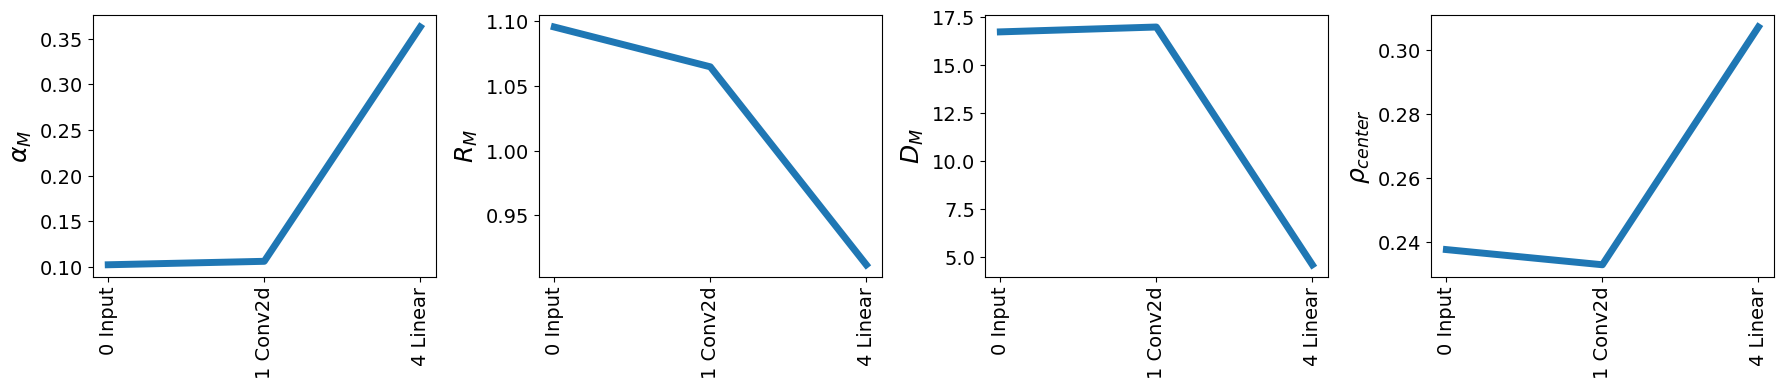

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

axes[0].plot(capacities, linewidth=5)
axes[1].plot(radii, linewidth=5)
axes[2].plot(dimensions, linewidth=5)
axes[3].plot(correlations, linewidth=5)

axes[0].set_ylabel(r'$\alpha_M$', fontsize=18)
axes[1].set_ylabel(r'$R_M$', fontsize=18)
axes[2].set_ylabel(r'$D_M$', fontsize=18)
axes[3].set_ylabel(r'$\rho_{center}$', fontsize=18)

names = list(activations.keys())
names = [n.split('_')[1] + ' ' + n.split('_')[2] for n in names]
for ax in axes:
    ax.set_xticks([i for i, _ in enumerate(names)])
    ax.set_xticklabels(names, rotation=90, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.show()

✨**What I found** 
- Even in this simple conv1d+linear classifier, we can see manifold capacity increases in the later layers. The fully connected layer is set right before classification. It matches our intuition that a good manifold capacity is necessary to classify classes accurately! 

📚**What I learned** 
- Manifold capacity $\alpha_{M}$ implies 
  1. How linearly separable are the object manifolds.
  2. How many object manifolds can be put into the manifold space without too much clustering.
- It describes task level performance, and it can be connected by represnetational level geometry measures as
$$\alpha_{M} = f(\kappa, R_{M}, D_{M})$$
- In addition, we can calculate the averaged pairwise manifold centroid correlation $\rho_{center}$ with cosine similarity. 
The relationship of the four measures can be summarized as:

<div style="text-align: center">

| Measure   | Tangled manifolds | Untangled manifolds |
|-----------|------------------|---------------------|
| $\alpha_{M}$  | ⬇️ | ⬆️ |
| $R_{M}$  | ⬆️ | ⬇️  |
| $D_{M}$  | ⬆️ | ⬇️  |
| $\rho_{center}$  | ⬆️ | ⬇️  |

</div>


## Model metamers and adversarial examples

Model metamers are stimuli that are matched to the activations of a model (ie the model "sees" them as the same) but that can be very different in pixel space. See the following papers for examples of how we can use these as a test of a model's similarity with humans: 
https://www.biorxiv.org/content/10.1101/2022.05.19.492678v1  

https://proceedings.neurips.cc/paper/2019/file/ac27b77292582bc293a51055bfc994ee-Paper.pdf

Adverarial examples are stimuli that are very close in pixel space but can cause the model to respond very differently. These are often studied in the machine learning community due to security reasons. Some references here: 
https://arxiv.org/abs/1412.6572

Try to generate a model metamer or adversarial example for your trained network!  



In [16]:
from example_task_utils import net_extraxtor, generate_random_image
import copy 

### Get referenced stimuli and initial metamer

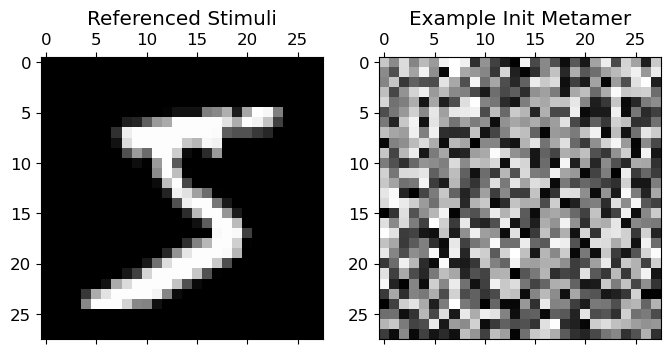

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plot the referenced stimuli on the first subplot
axs[0].matshow(train_dataset[0][0][0], cmap='gray')
axs[0].set_title('Referenced Stimuli')

# Generate a random image as init metamer and plot it on the second subplot
example_random_img = generate_random_image((1, 28, 28))
axs[1].matshow(example_random_img[0], cmap='gray')
axs[1].set_title('Example Init Metamer')

plt.show()

### Extract subnetworks from the model

In [18]:
nets = net_extraxtor(model)
nets

{'conv': Sequential(
   (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
 ),
 'relu': Sequential(
   (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
   (1): ReLU()
 ),
 'flatten': Sequential(
   (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
   (1): ReLU()
   (2): Flatten(start_dim=-3, end_dim=-1)
 ),
 'fc': Sequential(
   (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
   (1): ReLU()
   (2): Flatten(start_dim=-3, end_dim=-1)
   (3): Linear(in_features=21632, out_features=10, bias=True)
 ),
 'softmax': Sequential(
   (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
   (1): ReLU()
   (2): Flatten(start_dim=-3, end_dim=-1)
   (3): Linear(in_features=21632, out_features=10, bias=True)
   (4): LogSoftmax(dim=1)
 )}

### Genearte the model metamers for early and later layers

In [19]:
def train_metamer(net, input, metamer, optimizer, criterion, device):
    net.eval()
    loss = 0.0

    input = input.to(device)
    metamer = metamer.to(device)
    input_activation = net(input)
    metamer_activation = net(metamer)
    # print(input_activation.shape, metamer_activation.shape)

    loss = criterion(input_activation, metamer_activation) 
    loss.backward()
    optimizer.step()

    return metamer, loss.item(), input_activation, metamer_activation, input

  0%|          | 0/100 [00:00<?, ?it/s]

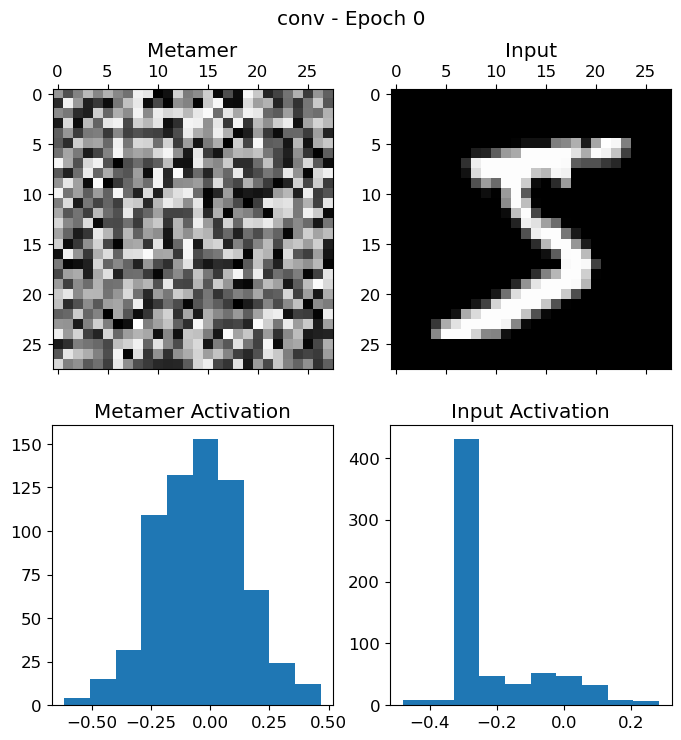

  1%|          | 1/100 [00:00<00:28,  3.53it/s]

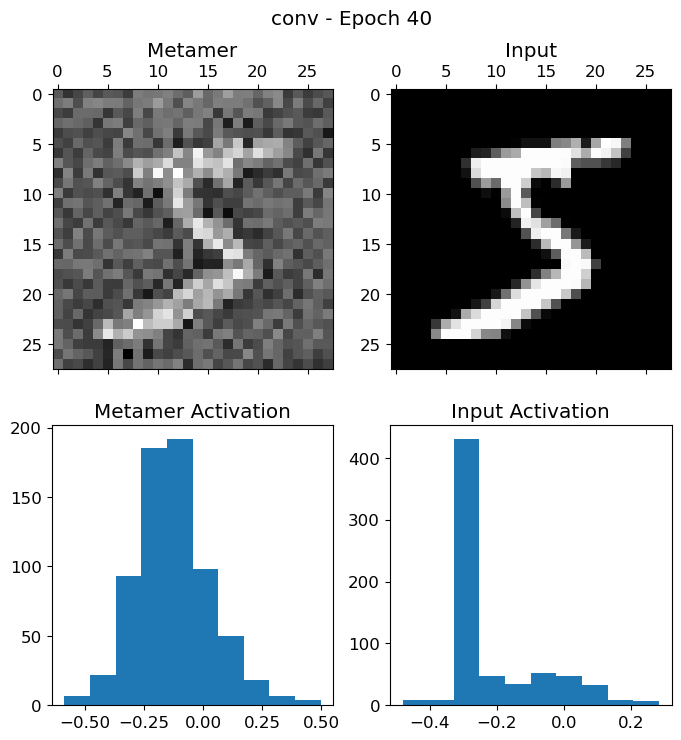

 41%|████      | 41/100 [00:00<00:00, 81.42it/s]

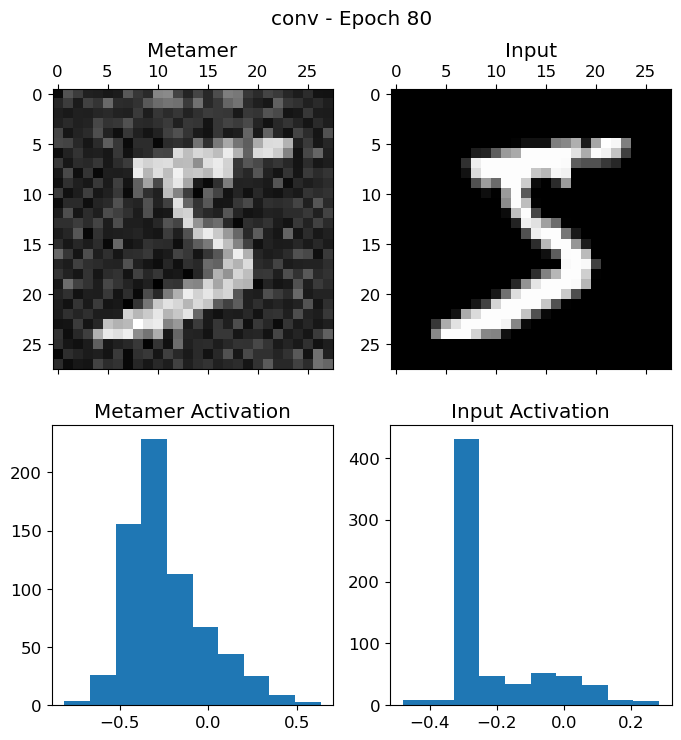

  0%|          | 0/100 [00:00<?, ?it/s]

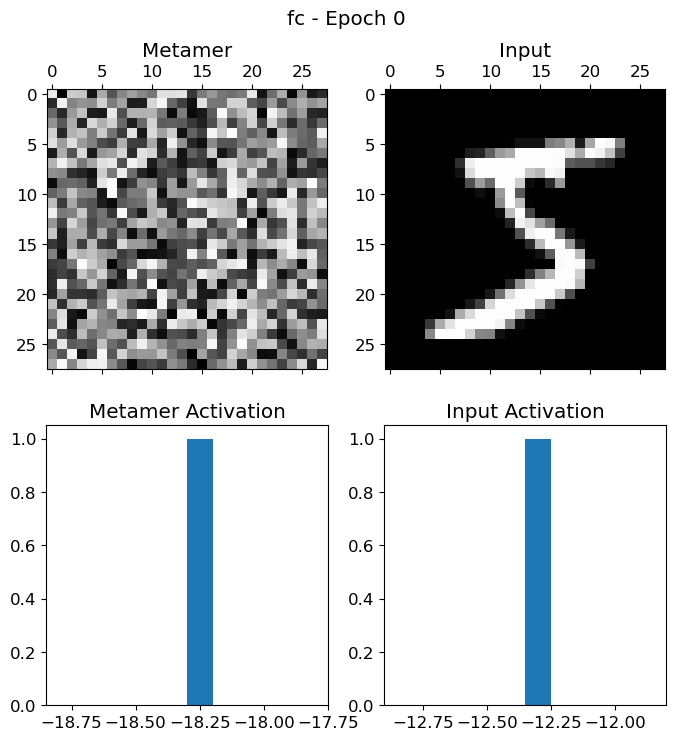

  1%|          | 1/100 [00:00<00:27,  3.54it/s]

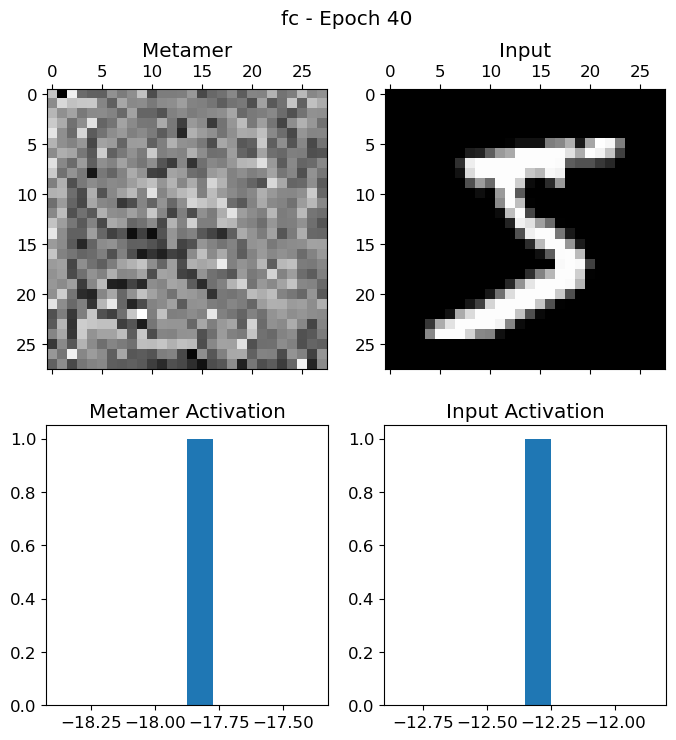

 41%|████      | 41/100 [00:00<00:00, 71.56it/s]

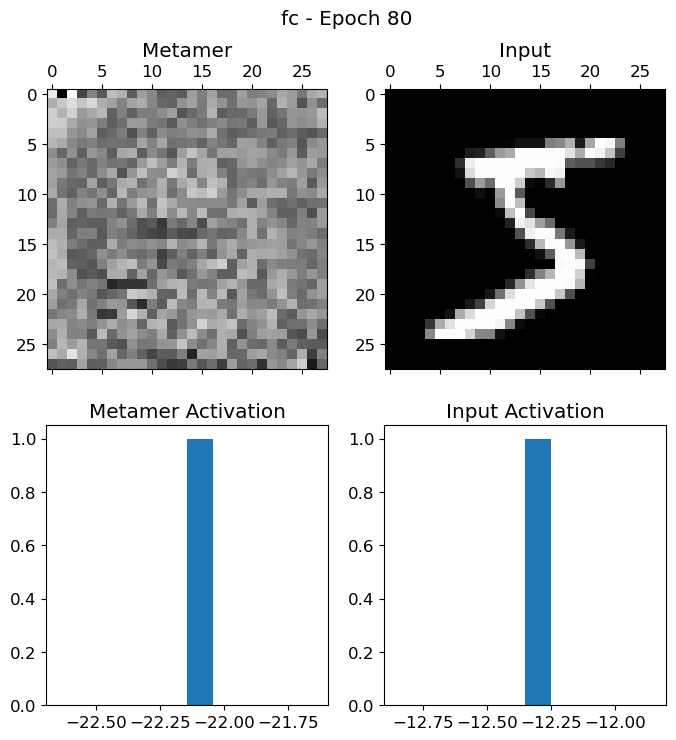

100%|██████████| 100/100 [00:01<00:00, 93.22it/s]


In [20]:
######################
###### Training ######
######################
best_metamers = {"conv": None, "fc": None}
losses = {"conv": None, "fc": None}

for layer in ["conv", "fc"]:
    # Referenced stimuli
    sample_input = train_dataset[0][0]

    # Generate init metamar with random gaussian noise with the specified size
    random_img = generate_random_image((1, 28, 28))
    # random_img = generate_random_image((1, 28, 28))
    # random_img = torch.zeros_like(random_img) # tried to start with a black image during debugging
                                                # while it is hacking, it leads to easier convergence as expected 
    # Save for later comparison
    metamer = random_img.clone()

    # Only input metamer requires gradient
    metamer.requires_grad = True

    # Get the submodule of the specified layer
    submodule = nets[layer]
    submodule.eval()
    submodule.to(device)

    # Freeze model parameters
    for name, para in submodule.named_parameters():
        para.requires_grad = False

    assert len([p for p in submodule.parameters() if p.requires_grad]) == 0, "submodule should not have any trainable parameters"

    optimizer = optim.Adam([metamer], lr=1e-2) # should only metamer be optimizable, key step during debugging

    criterion = nn.MSELoss() 
    # criterion = inversion_loss # customized loss tried during debugging

    best_metamer = metamer
    best_loss = 1e10
    loss = []

    for i in tqdm(range(100)):
        submodule_prev = copy.deepcopy(submodule)

        metamer, epoch_loss, input_activation, metamer_activation, input = train_metamer(submodule, sample_input, metamer, optimizer, criterion, device)

        # Save the best metamer
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_metamer = metamer

        ## Asserts
        # Metamer should change
        assert torch.sum(metamer - random_img) != 0, metamer - random_img
        # Sample input should not change
        assert torch.sum(input - sample_input) == 0, input - sample_input 
        # Model parameter should not change
        for (name1, param1), (name2, param2) in zip(submodule_prev.named_parameters(), submodule.named_parameters()):
            assert torch.allclose(param1.data, param2.data), f"Model parameter {name1} is not equal to {name2}"

        loss.append(epoch_loss)

        if i % 40 == 0:
            fig, axs = plt.subplots(2, 2, figsize=(8, 8))

            axs[0, 0].matshow(metamer[0].detach().numpy(), cmap='gray')
            axs[0, 0].set_title('Metamer')

            axs[0, 1].matshow(sample_input[0].detach().numpy(), cmap='gray')
            axs[0, 1].set_title('Input')

            axs[1, 0].hist(metamer_activation[0].detach().numpy().flatten())
            axs[1, 0].set_title('Metamer Activation')

            axs[1, 1].hist(input_activation[0].detach().numpy().flatten())
            axs[1, 1].set_title('Input Activation')

            fig.suptitle(f'{layer} - Epoch {i}')

            plt.show()

    best_metamers[layer] = best_metamer
    losses[layer] = loss


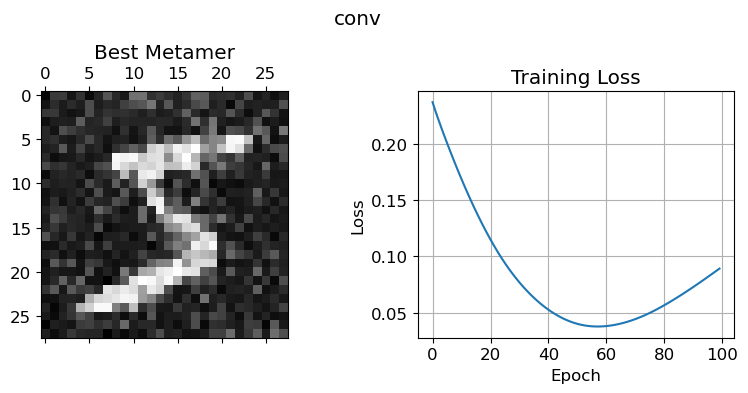

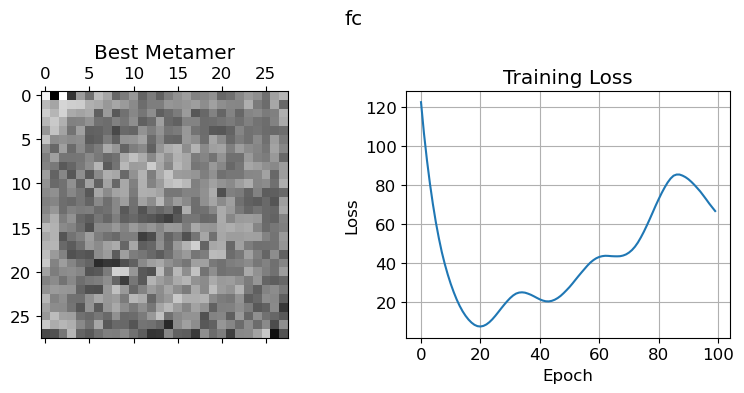

In [21]:
for layer in ["conv", "fc"]:
    best_metamer = best_metamers[layer]
    loss = losses[layer]

    # Plot the training loss and the best metamer
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    # Plot the best metamer
    axs[0].matshow(best_metamer[0].detach().numpy(), cmap='gray')
    axs[0].set_title('Best Metamer')

    # Plot the training loss 
    axs[1].plot(np.array(loss))
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Training Loss')
    axs[1].grid()

    fig.suptitle(f'{layer}')
    plt.tight_layout()
    plt.show()

✨**What I found** 
- The model metamer of the first layer (conv) is recognizable as the digit 5, while the model metamer of the layer right before 
classification (fc) is not. This conforms with the findings in [Feather et al., 2022](https://www.biorxiv.org/content/10.1101/2022.05.19.492678v1).

📚**What I learned**
- Concepts: 
  - Model metamer, which can reveal divergences in artificial and biological neural networks; and indication of metamer difference at different stages of a network. 
- Skills:
  - I learned how to implement a simple training pipeline to generate the model metamer for a classifier. Key steps:
    - Extracts the submodules of a network
    - Select the referenced stimuli
    - Proper random initialize the metamer 
    - Freeze the network and make the metamer as (the only) trainable parameters
    - Select the proper training epochs, for this toy task, best metamer emerges at a sub-100 epoch.

🦾**What I tried**
- I first tried to adapt code from the public [TF implementation](https://github.com/jenellefeather/model_metamers) and later [PyTorch implementation](https://github.com/jenellefeather/model_metamers_pytorch). I solved the package dependancy and went through the directory. But as the repo contains complex code base required to train on many models for both modalities, I found it unsuitable to adapt the code for this coding task. Rather, I started from the first principles and built the solution which we have now.